# Object Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect objects in images.

#### Move to base directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


## Preparation

Let's start with installing MediaPipe.

In [2]:
# !pip install -q mediapipe==0.10.0 --user

Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/object_detector#models) for more image classification models that you can use.

In [3]:
# !wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

### Timer class

In [61]:
from time import time

# Simples class to report execution time

class Timer:
    def __init__(self):
        self.start = time()
    def end(self, decimals=4):
        end = time() - self.start
        print('\n* TIME TO EXECUTE:', round(end, decimals), 's')
        

## Visualization utilities

In [4]:
#@markdown We implemented some functions to visualize the object detection results. <br/> Run the following cell to activate the functions.
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(image, detection_result) -> np.ndarray:
    """Draws bounding boxes on the input image and return it.
    Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
    Returns:
    Image with bounding boxes.
    """
    for detection in detection_result.detections:
        # Draw bounding_box
        bbox = detection.bounding_box
        start_point = bbox.origin_x, bbox.origin_y
        end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
        cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

        # Draw label and score
        category = detection.categories[0]
        category_name = category.category_name
        probability = round(category.score, 2)
        result_text = category_name + ' (' + str(probability) + ')'
        text_location = (MARGIN + bbox.origin_x,
                         MARGIN + ROW_SIZE + bbox.origin_y)
        cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                    FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

    return image

## Download test image

Let's grab a test image that we'll use later. This image comes from [Pixabay](https://pixabay.com/photos/pet-cute-animal-domestic-mammal-3157961/).

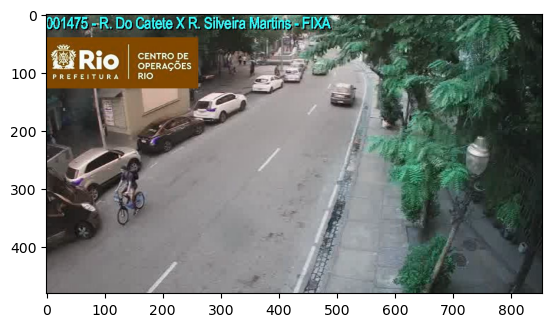

In [5]:
IMAGE_FILE = 'Dados/images/1475/reference/day/CODE1475_20230329_16-40-54.jpg'

import cv2
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

img = cv2.imread(IMAGE_FILE)
ax = plt.imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [6]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run object detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/object_detector/python) to learn more about configuration options that this solution supports.

### Object detection model file

In [113]:
model_asset_path = 'models/mediapipe/efficientdet_lite0.tflite'
model_asset_buffer = open(model_asset_path, 'rb').read()

class_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle',
    4: 'airplane', 5: 'bus', 6: 'train',
    7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter',
    13: 'bench', 14: 'bird', 15: 'cat',
    16: 'dog', 17: 'horse', 18: 'sheep',
    19: 'cow', 20: 'elephant', 21: 'bear',
    22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie',
    28: 'suitcase', 29: 'frisbee', 30: 'skis',
    31: 'snowboard', 32: 'sports ball',
    33: 'kite', 34: 'baseball bat', 35: 'baseball glove',
    36: 'skateboard', 37: 'surfboard', 38: 'tennis racket',
    39: 'bottle', 40: 'wine glass', 41: 'cup',
    42: 'fork', 43: 'knife', 44: 'spoon',
    45: 'bowl', 46: 'banana', 47: 'apple',
    48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza',
    54: 'donut', 55: 'cake', 56: 'chair',
    57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv',
    63: 'laptop', 64: 'mouse', 65: 'remote',
    66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink',
    72: 'refrigerator', 73: 'book', 74: 'clock',
    75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'
}

class_ids = {value: key for key, value in class_names.items()}

In [126]:
a = ''
for name in class_names.values():
    a += name + ', '
a

'person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush, '

### Load object detector model

##### METHOD #1

In [119]:
# LOAD OBJECT DETECTOR MODEL - METHOD #1

import mediapipe as mp
from mediapipe.tasks.python import vision

BaseOptions = mp.tasks.BaseOptions
ObjectDetector = mp.tasks.vision.ObjectDetector
ObjectDetectorOptions = mp.tasks.vision.ObjectDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode

t = Timer()
options = ObjectDetectorOptions(
    base_options=BaseOptions(
        model_asset_buffer=model_asset_buffer,
    ),
    max_results=5,
    running_mode=VisionRunningMode.IMAGE
)

detector = vision.ObjectDetector.create_from_options(options)
t.end()


* TIME TO EXECUTE: 2.8943 s


##### METHOD #2

In [80]:
# LOAD OBJECT DETECTOR MODEL - METHOD #2

# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

t = Timer()
# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(
    # model_asset_path=model_asset_path,
    model_asset_buffer=model_asset_buffer,
)
options = vision.ObjectDetectorOptions(
    base_options=base_options,
    score_threshold=0.1,
)

detector = vision.ObjectDetector.create_from_options(options)
t.end()


* TIME TO EXECUTE: 0.0692 s


### Load image and predict

C:\Users\luisr\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


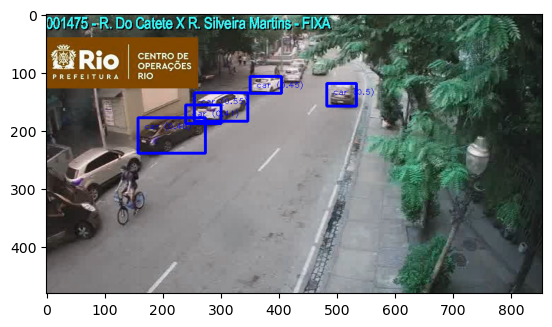

In [10]:
import numpy as np

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_annotated_image)

### Show single detection attributes

In [81]:
detection_result.detections[1]

Detection(bounding_box=BoundingBox(origin_x=483, origin_y=119, width=51, height=39), categories=[Category(index=None, score=0.5, display_name=None, category_name='car')], keypoints=[])

### Format detection output

In [118]:
def format_mediapipe_detection(detection_result):

    detections = []
    for detection in detection_result.detections:
        # detection = detection_result.detections[0]
        classes = detection.categories
        class_name = ctgrs[0].category_name
        class_id = class_ids[class_name]
        confidence = ctgrs[0].score
        bbox = detection.bounding_box

        x_min, y_min = bbox.origin_x, bbox.origin_y
        width, height = bbox.width, bbox.height
        x_max, y_max = x_min + width, y_min + height
        bbox = [x_min, y_min, x_max, y_max]
        detections.append([class_id, class_name, confidence, bbox])
        
    return detections

format_mediapipe_detection(detection_result)

[[2, 'car', 0.5, [255, 135, 347, 184]],
 [2, 'car', 0.5, [483, 119, 534, 158]],
 [2, 'car', 0.5, [158, 178, 274, 239]],
 [2, 'car', 0.5, [351, 107, 405, 136]],
 [2, 'car', 0.5, [240, 156, 301, 188]]]